In [32]:
import numpy as np
import matplotlib.pyplot as plt
from adaptive_sampling.processing_tools import mbar, thermodynamic_integration, gamd
from adaptive_sampling.units import *

### WTM-eABF

In [2]:
wtmeabf_traj = np.loadtxt('wtmeabf/CV_traj.dat', skiprows=1)

In [3]:
ext_sigma = 2.0    # thermal width of coupling between CV and extended variable 

# grid for free energy profile can be different than during sampling
minimum   = -50.0     
maximum   = 50.0    
bin_width = 2.0    
grid = np.arange(minimum, maximum, bin_width)

cv = wtmeabf_traj[:,1]  # trajectory of collective variable
la = wtmeabf_traj[:,2]  # trajectory of extended system

In [4]:
# run MBAR and compute free energy profile and probability density from statistical weights
traj_list, indices, meta_f = mbar.get_windows(grid, cv, la, ext_sigma, equil_temp=300.0)
weights = mbar.run_mbar(traj_list, meta_f, conv=1.0e-4, conv_errvec=None, outfreq=100, equil_temp=300.0)

Making Boltzmann factors

All ready!

Start of the self-consistent iteration.
Iter    1:	Conv=  0.2478941791	Conv_errvec=    914.991193
Iter  100:	Conv=  0.0061906914	Conv_errvec=     46.065140
Iter  200:	Conv=  0.0046777232	Conv_errvec=     29.830937
Iter  300:	Conv=  0.0032217947	Conv_errvec=     19.750205
Iter  400:	Conv=  0.0022087196	Conv_errvec=     13.393208
Iter  500:	Conv=  0.0015135086	Conv_errvec=      9.150809
Iter  600:	Conv=  0.0010370239	Conv_errvec=      6.265322
Iter  700:	Conv=  0.0007105285	Conv_errvec=      4.292097
Iter  800:	Conv=  0.0004868227	Conv_errvec=      2.940732
Iter  900:	Conv=  0.0003335484	Conv_errvec=      2.014897
Iter 1000:	Conv=  0.0002285317	Conv_errvec=      1.380543
Iter 1100:	Conv=  0.0001565791	Conv_errvec=      0.945899
Iter 1200:	Conv=  0.0001072805	Conv_errvec=      0.648093
Converged after 1219 iterations!
Max error vector: 0.6031671621694841


In [5]:
pmf, rho = mbar.pmf_from_weights(grid, cv[indices], weights, equil_temp=300.0)

In [6]:
# czar free energy estimate
czar_force = thermodynamic_integration.czar(grid, cv, la, ext_sigma, equil_temp=300.0)
pmf_ti, rho_ti = thermodynamic_integration.integrate(czar_force, bin_width, equil_temp=300.0)

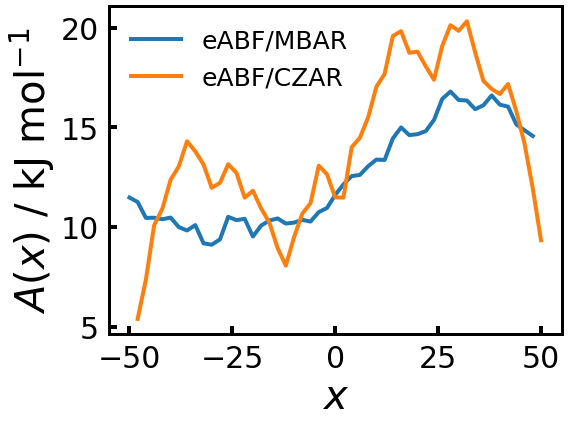

In [7]:
fig, axs = plt.subplots(1, figsize=(8,6))

axs.plot(grid, pmf, linewidth=4, label=r'eABF/MBAR')
axs.plot(grid+bin_width, pmf_ti, linewidth=4, label='eABF/CZAR')

axs.tick_params(axis='y',length=8,width=4,labelsize=30, pad=10, direction='in')
axs.tick_params(axis='x',length=8,width=4,labelsize=30, pad=10, direction='in')
#axs.grid()
axs.legend(fontsize=25, loc='best', frameon=False, shadow=False)
axs.set_xlabel(r'$x$', fontsize=40)
axs.set_ylabel(r'$A(x)$ / kJ mol$^{-1}$', fontsize=40)
axs.spines['bottom'].set_linewidth('3')
axs.spines['top'].set_linewidth('3')
axs.spines['left'].set_linewidth('3')
axs.spines['right'].set_linewidth('3')

fig.tight_layout()

### GaWTM-eABF

In [10]:
gawtmeabf_traj = np.loadtxt('gawtmeabf/CV_traj.dat', skiprows=1)

In [12]:
cv = gawtmeabf_traj[:,1]  # trajectory of collective variable
la = gawtmeabf_traj[:,2]  # trajectory of extended system
deltaU = gawtmeabf_traj[:,3]   # GaMD boost potential

In [17]:
# run MBAR and compute free energy profile and probability density from statistical weights
traj_list, indices, meta_f = mbar.get_windows(grid, cv, la, ext_sigma, equil_temp=300.0)
pot_list, _, _ = mbar.get_windows(grid, deltaU, la, ext_sigma, equil_temp=300.0)
weights = mbar.run_mbar(traj_list, meta_f, conv=1.0e-4, conv_errvec=None, outfreq=100, equil_temp=300.0, dV_list=pot_list)

Making Boltzmann factors

All ready!

Start of the self-consistent iteration.
Iter    1:	Conv=  0.7911992507	Conv_errvec=    831.608102
Iter  100:	Conv=  0.0039857253	Conv_errvec=    286.372813
Iter  200:	Conv=  0.0027877441	Conv_errvec=    128.231254
Iter  300:	Conv=  0.0018861307	Conv_errvec=     71.918053
Iter  400:	Conv=  0.0012764830	Conv_errvec=     45.456040
Iter  500:	Conv=  0.0008645518	Conv_errvec=     30.090043
Iter  600:	Conv=  0.0005857237	Conv_errvec=     20.235255
Iter  700:	Conv=  0.0003968590	Conv_errvec=     13.678279
Iter  800:	Conv=  0.0002689015	Conv_errvec=      9.261283
Iter  900:	Conv=  0.0001822025	Conv_errvec=      6.273901
Iter 1000:	Conv=  0.0001234573	Conv_errvec=      4.250839
Converged after 1055 iterations!
Max error vector: 3.431628667640325


In [28]:
pmf2, rho2 = mbar.pmf_from_weights(grid, cv[indices], weights, equil_temp=300.0)
pmf2 -= pmf2.min()

In [29]:
# czar free energy estimate
czar_force = thermodynamic_integration.czar(grid, cv, la, ext_sigma, equil_temp=300.0)
pmf_ti2, rho_ti2 = thermodynamic_integration.integrate(czar_force, bin_width, equil_temp=300.0)
pmf_ti2 -= pmf_ti2.min()

In [36]:
# correction from GaMD
correction = gamd.gamd_correction_n(grid, cv, deltaU * atomic_to_kJmol, korder=2, equil_temp=2)
pmf_ti2 += correction

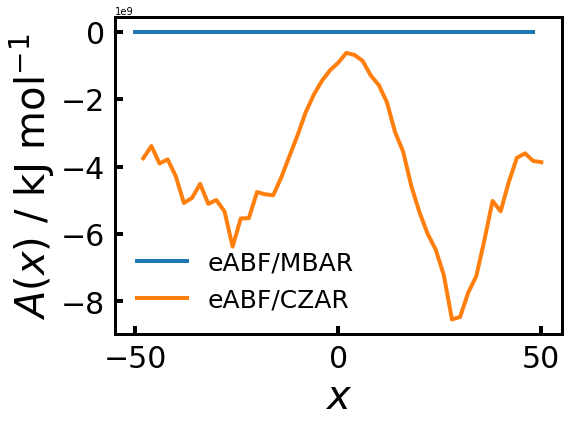

In [37]:
fig, axs = plt.subplots(1, figsize=(8,6))

axs.plot(grid, pmf2, linewidth=4, label=r'eABF/MBAR')
axs.plot(grid+bin_width, pmf_ti2, linewidth=4, label='eABF/CZAR')

axs.tick_params(axis='y',length=8,width=4,labelsize=30, pad=10, direction='in')
axs.tick_params(axis='x',length=8,width=4,labelsize=30, pad=10, direction='in')
#axs.grid()
axs.legend(fontsize=25, loc='best', frameon=False, shadow=False)
axs.set_xlabel(r'$x$', fontsize=40)
axs.set_ylabel(r'$A(x)$ / kJ mol$^{-1}$', fontsize=40)
axs.spines['bottom'].set_linewidth('3')
axs.spines['top'].set_linewidth('3')
axs.spines['left'].set_linewidth('3')
axs.spines['right'].set_linewidth('3')

fig.tight_layout()